In [477]:
"""
2026-01-07 Maria Yli-Heikkilä

Here we plot time series of Shannon index (supply diversity) that is calculated over all items of a country
after the rolling mean is applied.

What shall we do with the non-complete time series, e.g. post Soviet Union countries?

Should the dataset be normalized or left for the user to decide?

"""


import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import faostat
import warnings
import numpy as np
import os
import pickle

fp1 = '/Users/myliheik/Documents/myPython/FBSadjusted/data/metaDictM49Name.pkl'
fp2 = '/Users/myliheik/Documents/myPython/FBSadjusted/data/metaDictM49ISOa3.pkl'

M49Dict = pickle.load(open(fp1, 'rb')) 
ISOA3Dict = pickle.load(open(fp2, 'rb')) 

In [485]:
M49DictReverse = dict(zip(M49Dict.values(),M49Dict.keys()))
ISOA3DictReverse = dict(zip(ISOA3Dict.values(),ISOA3Dict.keys()))

In [364]:
# Check the latest release of the data by FAO in:
dffaostat = faostat.list_datasets_df()
dffaostat[dffaostat.code == 'FBS']

,code,label,date_update,note_update,release_current,state_current,year_current,release_next,state_next,year_next
4,FBS,Food Balances (2010-),2025-10-28,,2025-10-28,final,2023,2026-10,final,2024


In [ ]:
# Here we use results from:
# python 05-calculateShannonIndex.py -i /Users/myliheik/Documents/myPython/FBSadjusted/results/interpolatedLinear -y 2023 \
# -m /Users/myliheik/Documents/myPython/FBSadjusted/data/UNSD-countries-regions.csv

In [408]:
fp = '/Users/myliheik/Documents/myPython/FBSadjusted/results/shannon/Food-supply-quantity-kg-capita-yr-2023.csv'
# OR:
fp = '/Users/myliheik/Documents/myPython/FBSadjusted/results/shannon/Food-supply-kcal-capita-day-2023.csv'
dfShannon = pd.read_csv(fp)
dfShannon.head(1)

,1961-01-01 00:00:00,1962-01-01 00:00:00,1963-01-01 00:00:00,1964-01-01 00:00:00,1965-01-01 00:00:00,1966-01-01 00:00:00,1967-01-01 00:00:00,1968-01-01 00:00:00,1969-01-01 00:00:00,1970-01-01 00:00:00,...,Sub-region Code,Sub-region Name,Intermediate Region Code,Intermediate Region Name,Country or Area,ISO-alpha2 Code,ISO-alpha3 Code,Least Developed Countries (LDC),Land Locked Developing Countries (LLDC),Small Island Developing States (SIDS)
0,NaN,NaN,2.042673,2.052967,2.063865,2.072429,2.085613,2.099949,2.094554,2.10863,...,34.0,Southern Asia,NaN,NaN,Afghanistan,AF,AFG,x,x,NaN


In [407]:
filename = os.path.basename(fp)
myElement0 = filename.split('.')[0].replace('-', ' ')
myElement0

'Food supply kcal capita day 2023'

In [414]:
# These are the options to use for choosing plotting:
dfShannon.columns[~dfShannon.columns.str.startswith(('1', '2'))]

Index(['M49 Code', 'Global Code', 'Global Name', 'Region Code', 'Region Name',
       'Sub-region Code', 'Sub-region Name', 'Intermediate Region Code',
       'Intermediate Region Name', 'Country or Area', 'ISO-alpha2 Code',
       'ISO-alpha3 Code', 'Least Developed Countries (LDC)',
       'Land Locked Developing Countries (LLDC)',
       'Small Island Developing States (SIDS)'],
      dtype='object')

In [527]:
def plotShannon(dfShannon, areaVariable, myAreas, axes, palette, myElement):
    
    myAreas.append('Year')

    timeVariables = dfShannon.columns[dfShannon.columns.str.startswith(('1', '2'))].tolist()
    
    timeVariables.append(areaVariable)
    
    dfShannon2 = dfShannon[timeVariables].set_index(areaVariable)
    dfShannon3 = dfShannon2.transpose().rename_axis('Time').reset_index()
    dfShannon4 = dfShannon3.assign(Year = pd.to_datetime(dfShannon3.Time)) 

    #if 'South-eastern Asia' in dfShannon4.columns: 
    #    dfShannon4.rename(columns = {'South-eastern Asia': 'South-Eastern Asia'}, inplace = True)

    df6 = pd.melt(dfShannon4[myAreas], id_vars=['Year'], value_vars=myAreas, var_name = 'Area', 
                  value_name = 'Diversity in ' + myElement)
    
    # Fix typo in data:
    df6['Area'].replace(['South-eastern Asia'], ['South-Eastern Asia'], inplace = True)
    ax = sns.lineplot(df6, y = 'Diversity in ' + myElement, x = 'Year', hue = 'Area', palette=palette, ax = axes)

    ax.tick_params(axis='x', rotation=45)
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    ax.set_title(f'Diversity in {myElement}')
    ax.set_ylabel(f'Shannon index')
    ax.set_xlabel(f'Time')

In [534]:
def doPlotting(dfShannon, myAreas, areaVariable, ax, palette2, myElement):

    if areaVariable == 'Country or Area':
        # we are good to go:
        plotShannon(dfShannon, areaVariable, myAreas, ax, palette2, myElement)
    else:
        # we need to pick regions with M49 code:
        listOfRegions = []
        for i in myAreas:
            if not M49DictReverse.get(i):
                print(f'No M49 found for {i}')
                myAreas.remove(i)
            else:
                listOfRegions.append(dfShannon[dfShannon['M49 Code'] == M49DictReverse.get(i)])
        df = pd.concat(listOfRegions)
        # We make 'Country or Area' for regions:
        df['Country or Area'] = df['M49 Code'].map(M49Dict)
        plotShannon(df, 'Country or Area', myAreas, ax, palette2, myElement)

<function matplotlib.pyplot.show(close=None, block=None)>

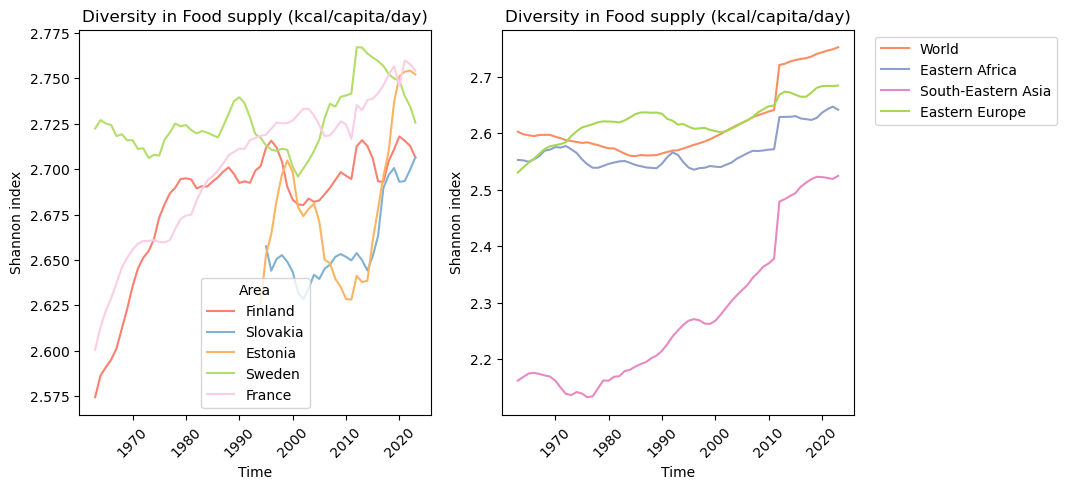

In [535]:
palette2 = sns.color_palette("Set3")[3:] 

warnings.filterwarnings("ignore")

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

areaVariable = 'Country or Area'
myAreas = ['Finland', 'Slovakia', 'Estonia', 'Sweden', 'France']

doPlotting(dfShannon, myAreas, areaVariable, ax1, palette2, myElement)

myAreas = ['World', 'Eastern Africa', 'South-eastern Asia', 'Eastern Europe']
areaVariable = 'M49 Code'

doPlotting(dfShannon, myAreas, areaVariable, ax2, palette11, myElement)

plt.show

In [456]:
dfShannon['Sub-region Name'].unique()

array(['Southern Asia', 'Southern Europe', 'Northern Africa',
       'Sub-Saharan Africa', 'Latin America and the Caribbean',
       'Western Asia', 'Australia and New Zealand', 'Western Europe',
       'Eastern Europe', 'South-eastern Asia', 'Northern America', nan,
       'Eastern Asia', 'Northern Europe', 'Melanesia', 'Polynesia',
       'Central Asia', 'Micronesia'], dtype=object)

<function matplotlib.pyplot.show(close=None, block=None)>

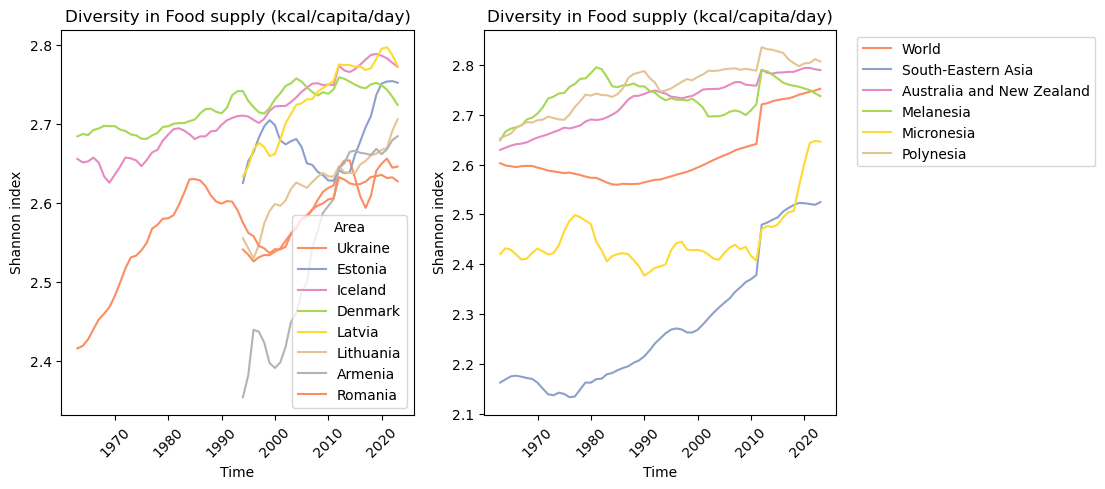

In [537]:
palette2 = sns.color_palette("Set3")[3:] 
warnings.filterwarnings("ignore")

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

areaVariable = 'Country or Area'
myAreas = ['Ukraine', 'Estonia', 'Iceland', 'Denmark', 'Latvia', 'Lithuania', 'Armenia', 'Romania']
doPlotting(dfShannon, myAreas, areaVariable, ax1, palette11, myElement)

# nyt tarvitaan sanakirjoja M49 -> country names
# koska poimitaan M49 mukaan alueita
myAreas = ['World',
'South-eastern Asia',
'Australia and New Zealand',
'Melanesia',
'Micronesia',
'Polynesia']
areaVariable = 'M49 Code'

doPlotting(dfShannon, myAreas, areaVariable, ax2, palette11, myElement)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

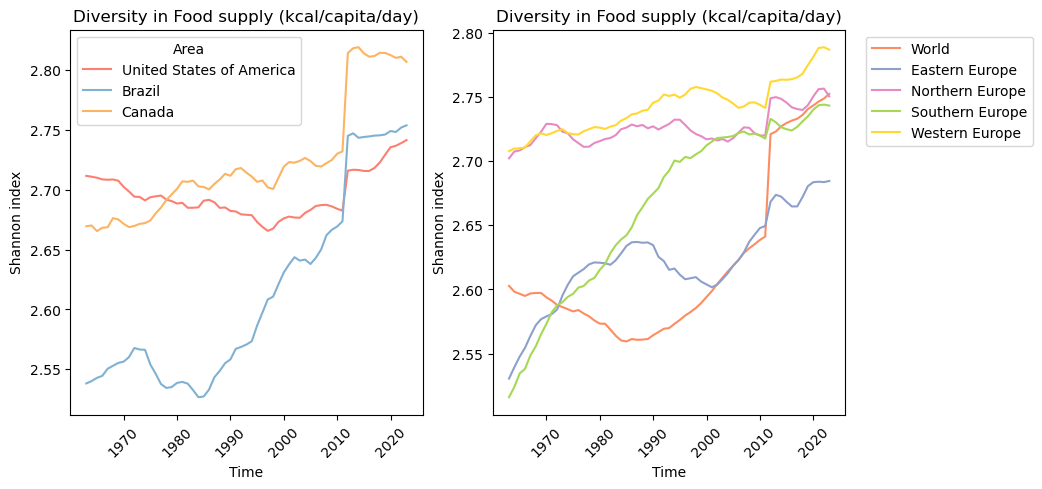

In [538]:
palette1 = sns.color_palette("Set2") 
palette11 = sns.color_palette("Set2")[1:]
palette2 = sns.color_palette("Set3")[3:] 

warnings.filterwarnings("ignore")

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

areaVariable = 'Country or Area'
myAreas = ['United States of America', 'Brazil', 'Canada'] # , 'Japan'] # Japan not found!

doPlotting(dfShannon, myAreas, areaVariable, ax1, palette2, myElement)

myAreas = ['World',
'Eastern Europe',
'Northern Europe',
'Southern Europe',
'Western Europe']
areaVariable = 'M49 Code'

doPlotting(dfShannon, myAreas, areaVariable, ax2, palette11, myElement)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

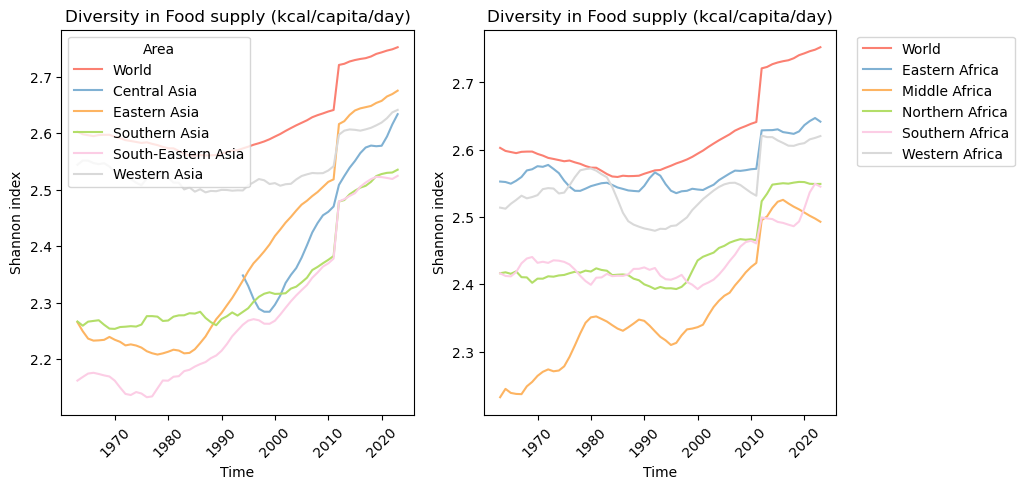

In [539]:
palette1 = sns.color_palette("Set2") 
palette11 = sns.color_palette("Set2")[1:]
palette2 = sns.color_palette("Set3")[3:] 

warnings.filterwarnings("ignore")

myElement = 'Food supply quantity (kg/capita/yr)'
myElement = 'Food supply (kcal/capita/day)'


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

myAreas = ['World',
'Central Asia',
'Eastern Asia',
'Southern Asia',
'South-eastern Asia',
'Western Asia',
]

areaVariable = 'M49 Code'

doPlotting(dfShannon, myAreas, areaVariable, ax1, palette2, myElement)

myAreas = ['World',
'Eastern Africa',
'Middle Africa',
'Northern Africa',
'Southern Africa',
'Western Africa']
areaVariable = 'M49 Code'

doPlotting(dfShannon, myAreas, areaVariable, ax2, palette2, myElement)

plt.show

In [553]:
EasternAfrica = dfShannon[dfShannon['Intermediate Region Name'] == 'Eastern Africa']['Country or Area'].tolist()
EasternAfrica.append('World')

No M49 found for Year


<function matplotlib.pyplot.show(close=None, block=None)>

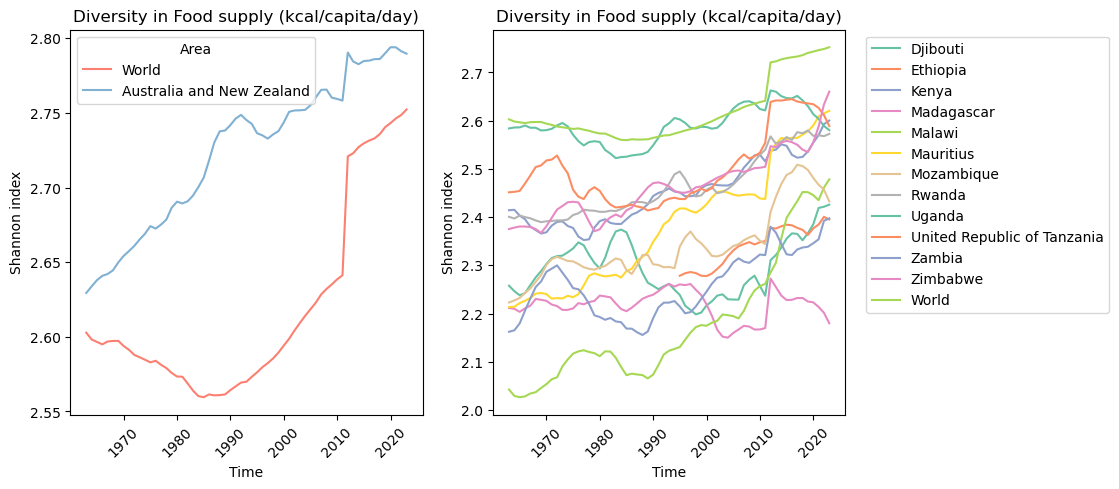

In [556]:
warnings.filterwarnings("ignore")

myElement = 'Food supply quantity (kg/capita/yr)'
myElement = 'Food supply (kcal/capita/day)'


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

areaVariable = 'M49 Code'
myAreas = EasternAfrica

doPlotting(dfShannon, myAreas, areaVariable, ax2, palette1, myElement)

myAreas = ['World',
'Australia and New Zealand'
]

areaVariable = 'M49 Code'

doPlotting(dfShannon, myAreas, areaVariable, ax1, palette2, myElement)

plt.show

In [15]:
#faostat.list_pars('FBS')
#faostat.get_par_df('FBS', 'itemsagg')

In [14]:
# from faostat: show the list of items in 'Stimulants' and 'Spices' (items aggregated)
#faostat.get_par_df('FBS', '2922>') # Stimulants > (List)
# I finally got the list from the faostat website, "FSB and SUA list" or 
# "Definitions and standards" -> "Item Group" -> download as file (FAOSTAT_data_1-22-2026.csv)

In [24]:
drop = ('Alcoholic Beverages', 'Beverages, Alcoholic', 'Wine', 'Beer', 'Cloves', 'Spices', 'Pepper', 'Pimento',
       'Spices, Other', 'Coffee and products', 'Cocoa Beans and products', 'Tea (including mate)')

## Maps

In [112]:
import geopandas as gpd

### World map GAMS

In [683]:
gdf0 = gpd.read_file('/Users/myliheik/Documents/GISdata/world/gadm_410-levels.gpkg', layer = "ADM_0")
gdf0.columns.tolist()

['GID_0', 'COUNTRY', 'geometry']

In [702]:
gdf54030all = gdf0.to_crs('ESRI:54030')

In [703]:
gdf54030 = gdf54030all[~(gdf54030all['COUNTRY'] == 'Antarctica')]

# Merge

In [707]:
# Merge:
dataForMaps = dfShannon[~dfShannon['ISO-alpha3 Code'].isna()]
gdfWorldGADM = gdf54030.merge(dataForMaps, left_on = 'GID_0',  right_on = 'ISO-alpha3 Code', how = 'left')

len(gdfWorldGADM), len(dfShannon), len(dataForMaps)

(262, 199, 163)

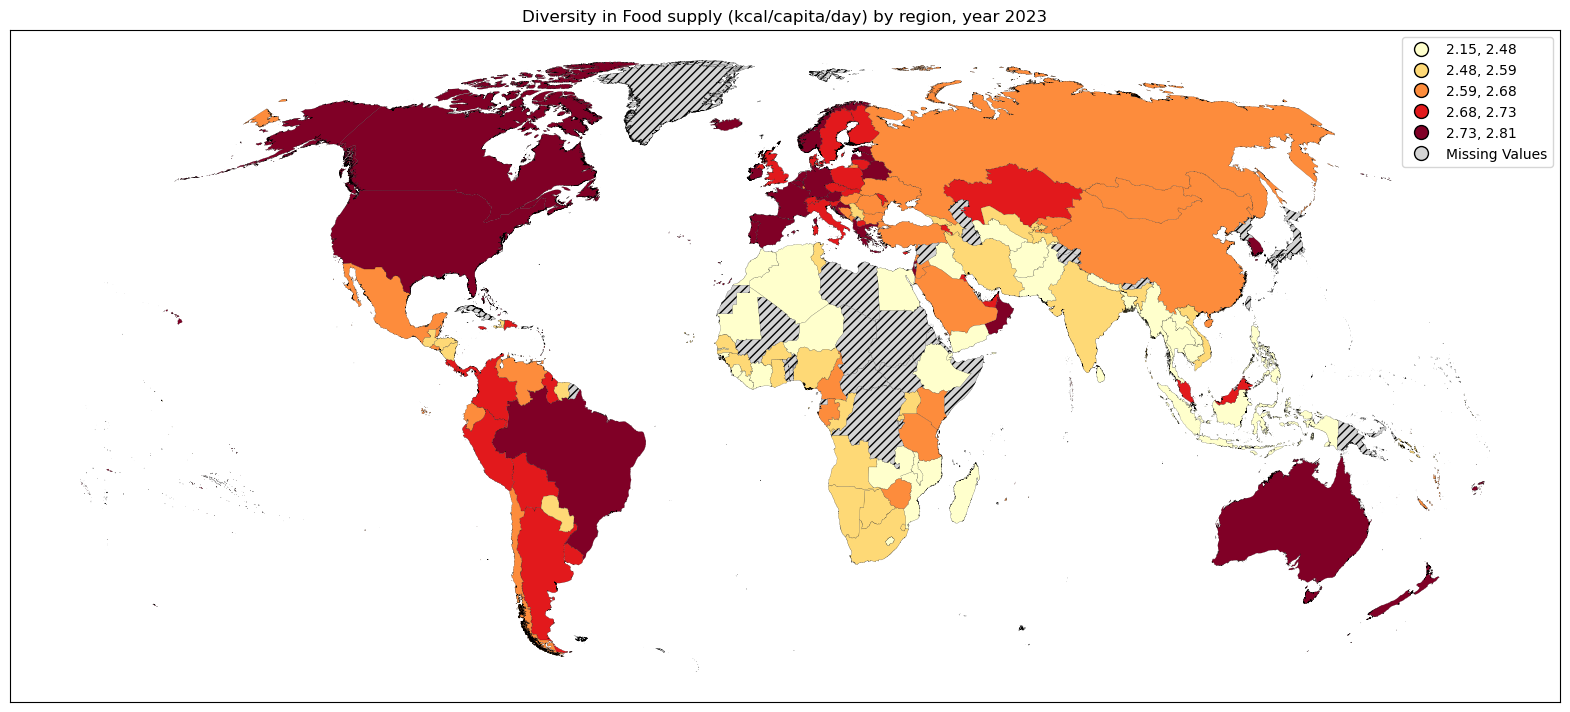

In [708]:
Year = '2023'

# initialize an empty figure and add an axis
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()

# plot a basic map of the world
#gdf54030.plot(
#    ax=ax,
##    color="lightgray",
#    edgecolor="black",
#    alpha=0.5
#)

# plot countries:
gdfWorldGADM.plot(
    scheme='quantiles', cmap='YlOrRd',
    ax=ax,
    column = f'{Year}-01-01 00:00:00',
    edgecolor="black",
    legend=True,
    linewidth = 0.1, 

           missing_kwds = {
               'color' : 'lightgrey',
               'hatch': '////' ,
               'label' : 'Missing Values'

           }

)

for legend_handle in ax.get_legend().legend_handles:
    legend_handle.set_markeredgewidth(1)
    legend_handle.set_markeredgecolor("black")

# turn off axis ticks
ax.set_xticks([])
ax.set_yticks([])

# set the plot title
plt.title(f'Diversity in {myElement} by region, year {Year}')

plt.show()

### World map Natural Earth

In [691]:
# load the low resolution world map
world = gpd.read_file('~/Documents/GISdata/world/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')
world[world['ADMIN'] == 'Norway']['UN_A3']
# There is no ISO A3 code for Norway, don't use this.

21    -99
Name: UN_A3, dtype: object

In [709]:
world[world['ISO_A3'] == '-99']

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
21,Admin-0 country,1,3,Norway,NOR,0,2,Sovereign country,None,Norway,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((15.14282 79.67431, 15.52255 80..."
43,Admin-0 country,1,2,France,FR1,1,2,Country,1,France,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-51.6578 4.15623, -52.24934 3...."
160,Admin-0 country,1,6,Northern Cyprus,CYN,0,2,Sovereign country,1,Northern Cyprus,...,Admin-0 country,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,"POLYGON ((32.73178 35.14003, 32.80247 35.1455,..."
167,Admin-0 country,1,5,Somaliland,SOL,0,2,Sovereign country,1,Somaliland,...,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,"POLYGON ((48.9482 11.41062, 48.9482 11.41062, ..."
174,Admin-0 country,1,6,Kosovo,KOS,0,2,Disputed,1,Kosovo,...,Admin-0 country,Unrecognized,Admin-0 country,Unrecognized,Admin-0 country,Admin-0 country,Admin-0 country,Admin-0 country,Unrecognized,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."


In [102]:

regionsFAO = faostat.get_par_df('FBS', 'regions')
countriesFAO = faostat.get_par_df('FBS', 'countries')

In [717]:
#dfShannon[dfShannon['Country or Area'].str.startswith('United')]
tmp = dfShannon[~dfShannon['Country or Area'].isna()]
tmp[tmp['Country or Area'].str.startswith('United')]['Country or Area']

153                                 United Arab Emirates
154    United Kingdom of Great Britain and Northern I...
155                          United Republic of Tanzania
156                             United States of America
Name: Country or Area, dtype: object

In [718]:
tmp[tmp['Country or Area'] == 'Japan']

,1961-01-01 00:00:00,1962-01-01 00:00:00,1963-01-01 00:00:00,1964-01-01 00:00:00,1965-01-01 00:00:00,1966-01-01 00:00:00,1967-01-01 00:00:00,1968-01-01 00:00:00,1969-01-01 00:00:00,1970-01-01 00:00:00,...,Sub-region Code,Sub-region Name,Intermediate Region Code,Intermediate Region Name,Country or Area,ISO-alpha2 Code,ISO-alpha3 Code,Least Developed Countries (LDC),Land Locked Developing Countries (LLDC),Small Island Developing States (SIDS)


In [719]:
tmp[tmp['Country or Area'] == 'Norway']

,1961-01-01 00:00:00,1962-01-01 00:00:00,1963-01-01 00:00:00,1964-01-01 00:00:00,1965-01-01 00:00:00,1966-01-01 00:00:00,1967-01-01 00:00:00,1968-01-01 00:00:00,1969-01-01 00:00:00,1970-01-01 00:00:00,...,Sub-region Code,Sub-region Name,Intermediate Region Code,Intermediate Region Name,Country or Area,ISO-alpha2 Code,ISO-alpha3 Code,Least Developed Countries (LDC),Land Locked Developing Countries (LLDC),Small Island Developing States (SIDS)
112,NaN,NaN,2.700127,2.707067,2.709831,2.714866,2.720479,2.730419,2.731117,2.737405,...,154.0,Northern Europe,NaN,NaN,Norway,NO,NOR,NaN,NaN,NaN


In [721]:
tmp[tmp['Country or Area'] == 'France']

,1961-01-01 00:00:00,1962-01-01 00:00:00,1963-01-01 00:00:00,1964-01-01 00:00:00,1965-01-01 00:00:00,1966-01-01 00:00:00,1967-01-01 00:00:00,1968-01-01 00:00:00,1969-01-01 00:00:00,1970-01-01 00:00:00,...,Sub-region Code,Sub-region Name,Intermediate Region Code,Intermediate Region Name,Country or Area,ISO-alpha2 Code,ISO-alpha3 Code,Least Developed Countries (LDC),Land Locked Developing Countries (LLDC),Small Island Developing States (SIDS)
52,NaN,NaN,2.600693,2.613048,2.622097,2.62894,2.637153,2.645895,2.651179,2.655667,...,155.0,Western Europe,NaN,NaN,France,FR,FRA,NaN,NaN,NaN
